# Initialization

## Import

### Import Modules

In [1]:
import gc
import time

import numpy as np
from matplotlib import pyplot as plt

from tasks.optic_disc_cup.datasets import DrishtiDataset, RimOneDataset
from tasks.optic_disc_cup.metrics import calc_disc_cup_iou
from config.config_type import AllConfig, DataConfig, DataTuneConfig, LearnConfig, WeaselConfig
from data.dataset_loaders import DatasetLoaderParamSimple
from data.types import SparsityValue
from learners.protoseg import ProtoSegLearner
from learners.weasel import WeaselLearner
from models.u_net import UNet

from torch import cuda

plt.style.use('dark_background')

### Autoreload Import

In [2]:
%reload_ext autoreload
%autoreload 1
%aimport config.config_type
%aimport models.u_net
%aimport data.types, data.few_sparse_dataset, data.dataset_loaders
%aimport learners.learner, learners.weasel, learners.protoseg
%aimport tasks.optic_disc_cup.datasets, tasks.optic_disc_cup.metrics

In [3]:
%autoreload now

## All Config

### Short Training

In [4]:
data_config: DataConfig = {
    'num_classes': 3,
    'num_channels': 3,
    'num_workers': 0,
    'batch_size': 1,
    'resize_to': (256, 256)
}

data_tune_config: DataTuneConfig = {
    'shot_list': [5],
    'sparsity_dict': {
        'point': [50],
        'grid': [10],
        'contour': [1],
        'skeleton': [1],
        'region': [1]
    }
}

learn_config: LearnConfig = {
    'should_resume': False,
    'use_gpu': True,
    'num_epochs': 8,
    'optimizer_lr': 1e-3,
    'optimizer_weight_decay': 5e-5,
    'optimizer_momentum': 0.9,
    'scheduler_step_size': 150,
    'scheduler_gamma': 0.2,
    'tune_freq': 4,
    'exp_name': ''
}

weasel_config: WeaselConfig = {
    'use_first_order': False,
    'update_param_step_size': 0.3,
    'tune_epochs': 6,
    'tune_test_freq': 3
}

all_config: AllConfig = {
    'data': data_config,
    'data_tune': data_tune_config,
    'learn': learn_config,
    'weasel': weasel_config
}

### Long Training

In [5]:
# data_config: DataConfig = {
#     'num_classes': 3,
#     'num_channels': 3,
#     'num_workers': 0,
#     'batch_size': 1,
#     'resize_to': (256, 256)
# }

# data_tune_config: DataTuneConfig = {
#     'shot_list': [20],
#     'sparsity_dict': {
#         'point': [50],
#         'grid': [10],
#         'contour': [1],
#         'skeleton': [1],
#         'region': [1]
#     }
# }

# learn_config: LearnConfig = {
#     'should_resume': False,
#     'use_gpu': True,
#     'num_epochs': 200,
#     'optimizer_lr': 1e-3,
#     'optimizer_weight_decay': 5e-5,
#     'optimizer_momentum': 0.9,
#     'scheduler_step_size': 150,
#     'scheduler_gamma': 0.2,
#     'tune_freq': 40,
#     'exp_name': ''
# }

# weasel_config: WeaselConfig = {
#     'use_first_order': False,
#     'update_param_step_size': 0.3,
#     'tune_epochs': 40,
#     'tune_test_freq': 8
# }

# all_config: AllConfig = {
#     'data': data_config,
#     'data_tune': data_tune_config,
#     'learn': learn_config,
#     'weasel': weasel_config
# }

# Dataset Exploration

## RIM-ONE

### Create Dataset

In [6]:
rim_one_sparsity_params: dict = {
    'point_dot_size': 1,
    'grid_dot_size': 1,
    'contour_radius_dist': 4,
    'contour_radius_thick': 2,
    'skeleton_radius_thick': 4,
    'region_compactness': 0.5
}

rim_one_data = RimOneDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=rim_one_sparsity_params
)

### Check Sparse Masks

C:\Users\pandega\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(256, 256, 3) 197 4 r3_G-2-R_left_half
(256, 256) int8 [0 1 2]


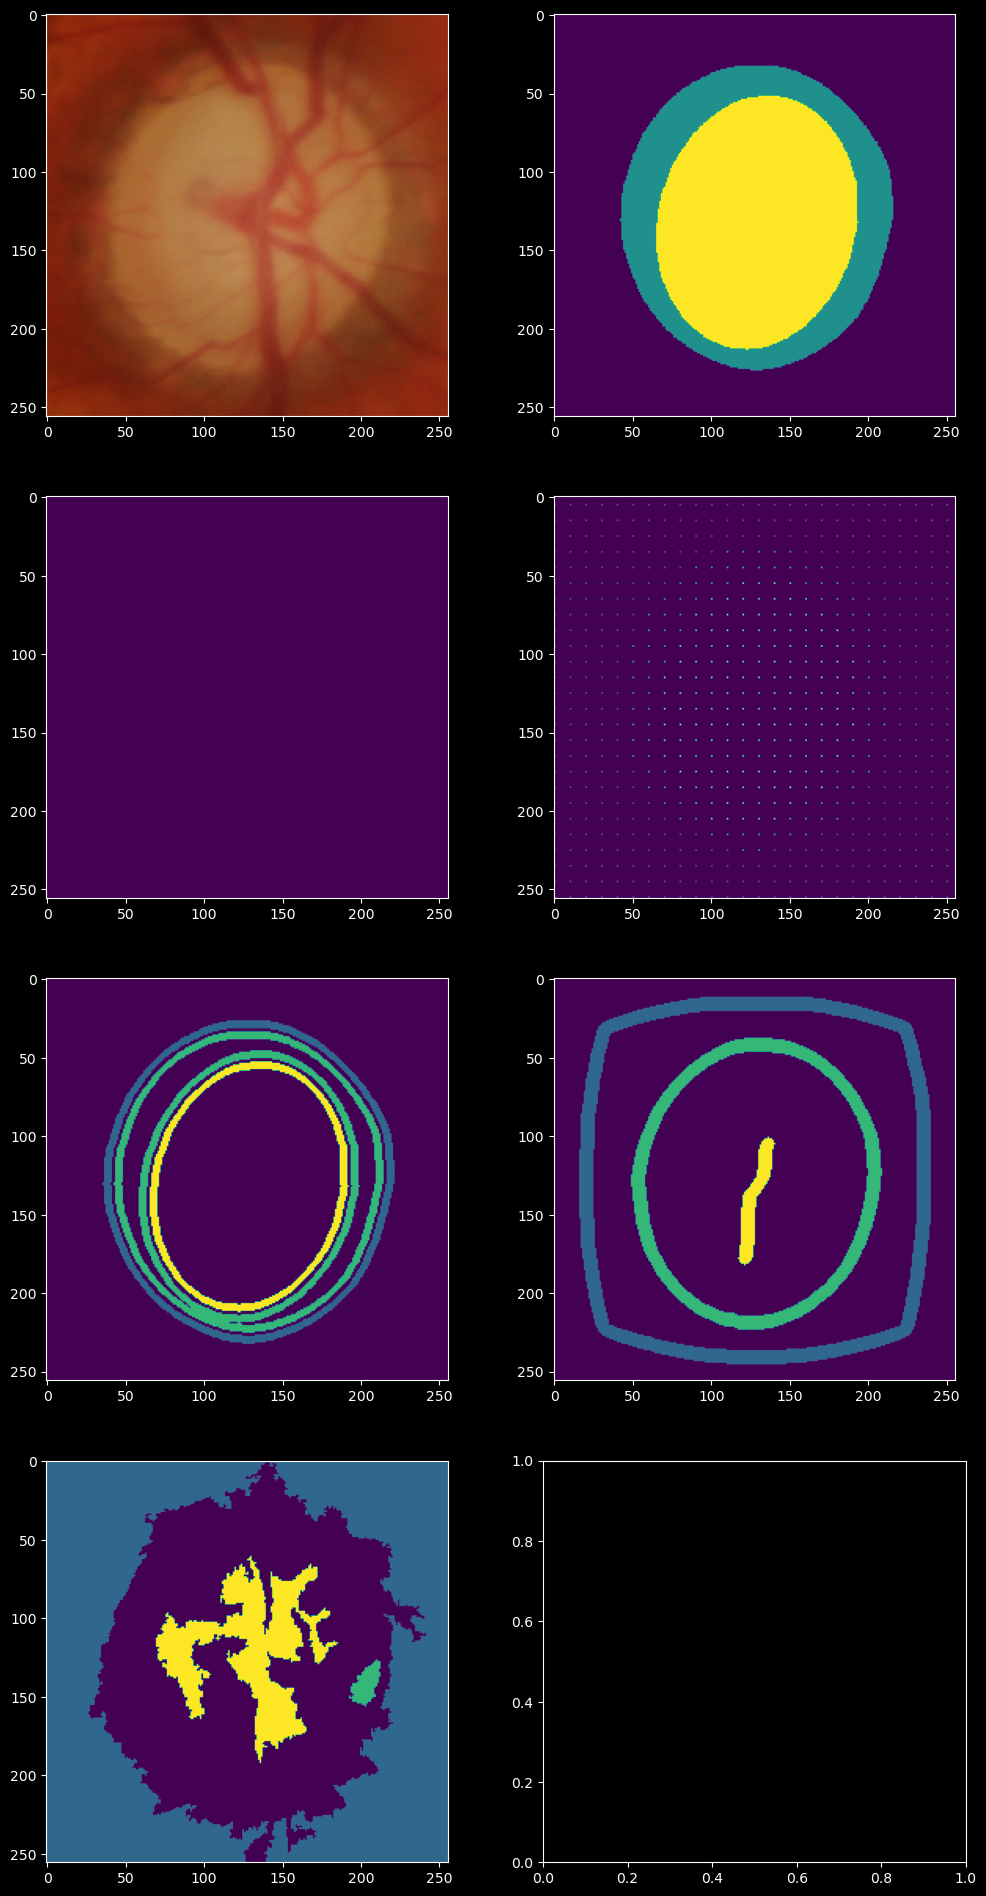

In [7]:
sparsity_values: dict[str, SparsityValue] = {
    'point': 50,
    'grid': 10,
    'contour': 1,
    'skeleton': 1,
    'region': 1,
}
image, mask, sparse_masks, image_filename = rim_one_data.get_data_with_sparse_all(0, sparsity_values)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1 
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask)
for i, sparsity in enumerate(sparse_masks):
    axs[i+2].imshow(sparse_masks[sparsity])

### Check Others

In [8]:
# image_sizes = []
# for image_path, mask_path in rim_one_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

## DRISHTI

### Create Dataset

In [9]:
drishti_sparsity_params: dict = {
    'point_dot_size': 1,
    'grid_dot_size': 1,
    'contour_radius_dist': 4,
    'contour_radius_thick': 1,
    'skeleton_radius_thick': 3,
    'region_compactness': 0.5
}

drishti_data = DrishtiDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=drishti_sparsity_params
)

### Check Sparse Masks

(256, 256, 3) 187 9 045_cropped
(256, 256) int8 [0 1 2]


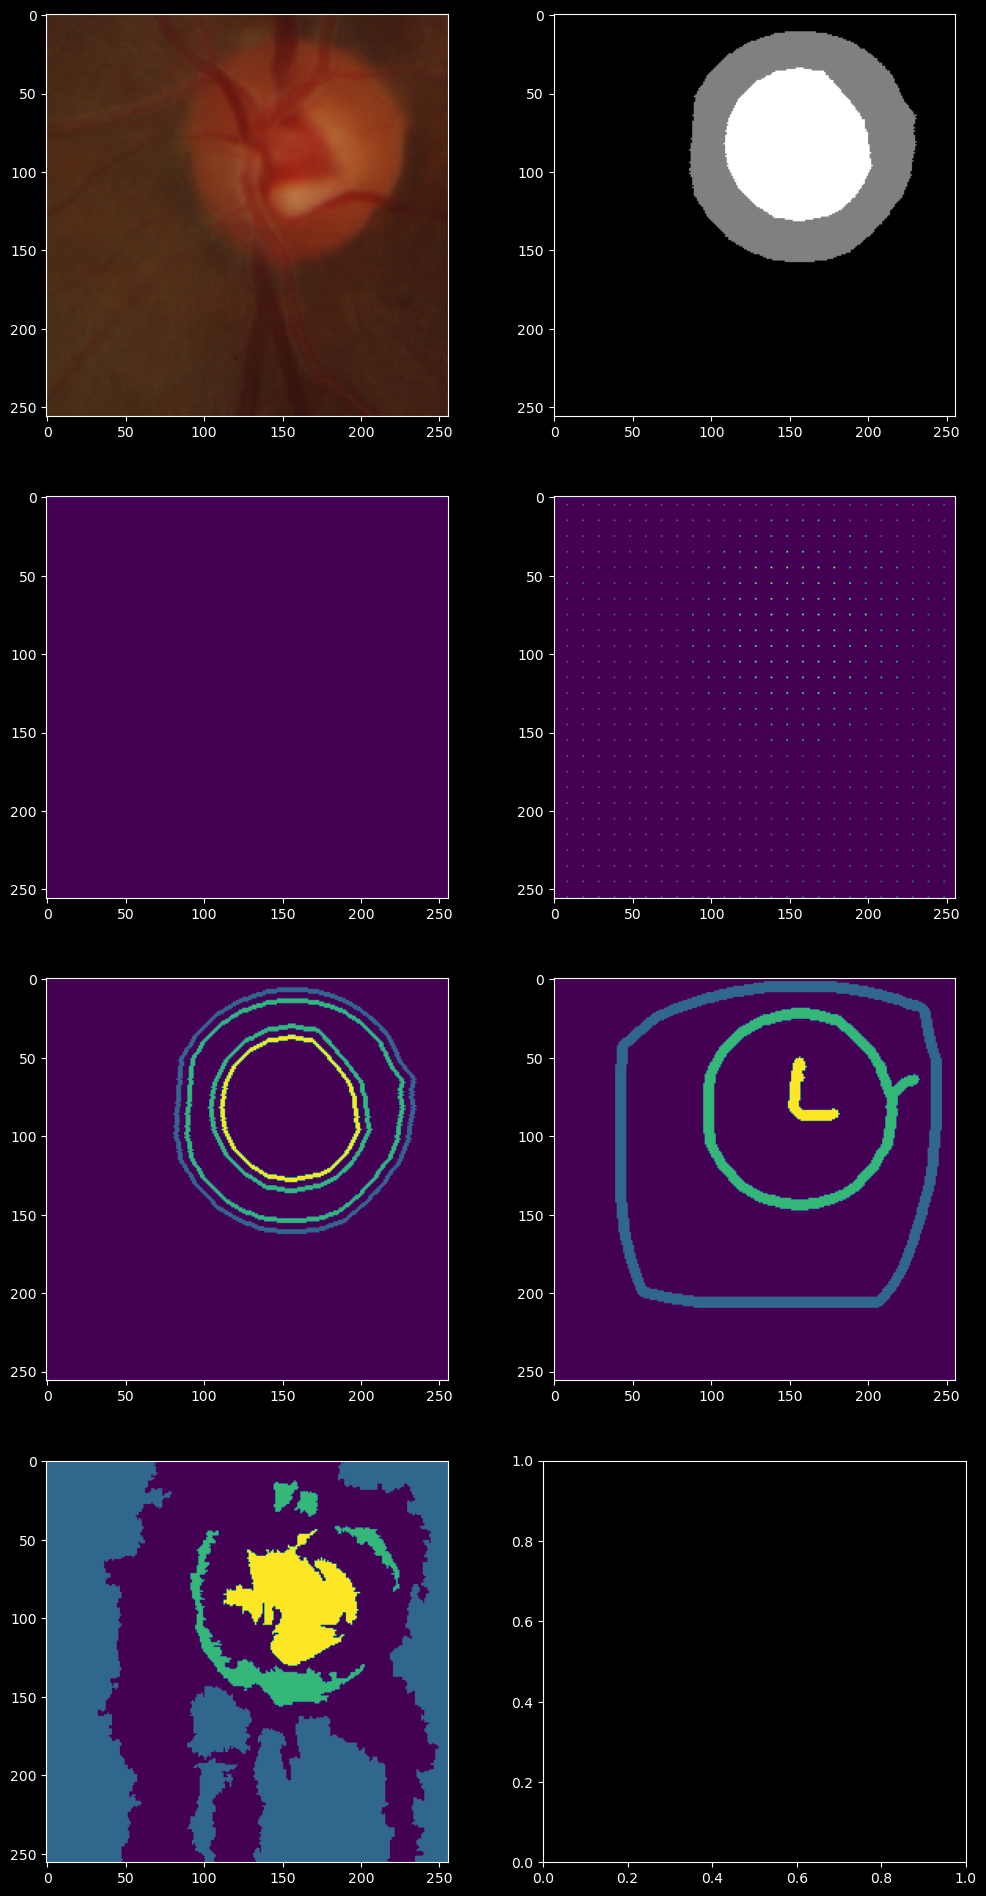

In [10]:
sparsity_values: dict[str, SparsityValue] = {
    'point': 50,
    'grid': 10,
    'contour': 1,
    'skeleton': 1,
    'region': 1,
}
image, mask, sparse_masks, image_filename = drishti_data.get_data_with_sparse_all(1, sparsity_values)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask, cmap='gray')
for i, sparsity in enumerate(sparse_masks):
    axs[i+2].imshow(sparse_masks[sparsity])

### Check Others

In [11]:
# image_sizes = []
# for image_path, mask_path in drishti_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

## Dataset Loader Params

In [ ]:
rim_one_meta_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': RimOneDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'num_shots': -1,
        'sparsity_mode': 'random',
        'sparsity_value': 'random',
        'sparsity_params': rim_one_sparsity_params
    }
}

drishti_tune_loader_params: DatasetLoaderParamSimple = {
    'dataset_class': DrishtiDataset,
    'dataset_kwargs': {
        'split_seed': 0,
        'split_test_size': 0.2,
        'sparsity_params': drishti_sparsity_params
    }
}

# Weasel Learner

## Initialization

### Update Config

In [12]:
all_config['data']['batch_size'] = 3
all_config['learn']['exp_name'] = 'WS RO-DR short dummy'
# all_config['learn']['exp_name'] = 'WS RO-DR short v2'
# all_config['learn']['exp_name'] = 'weasel_long_rimone_to_drishti'

### Create Model

In [19]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Create Learner

In [20]:
learner = WeaselLearner(net, all_config, [rim_one_meta_loader_params], drishti_tune_loader_params, calc_disc_cup_iou)

## Learning

In [21]:
learner.learn()

Start learning ...

Using GPU with total memory 2048MiB, 0.00% is already used
Ep: 1/8, data: 1/1, it: 1/8, loss: 0.9836
Ep: 1/8, data: 1/1, it: 2/8, loss: 0.6832
Ep: 1/8, data: 1/1, it: 3/8, loss: 1.6029
Ep: 1/8, data: 1/1, it: 4/8, loss: 0.6813
Ep: 1/8, data: 1/1, it: 5/8, loss: 0.9387
Ep: 1/8, data: 1/1, it: 6/8, loss: 0.9804
Ep: 1/8, data: 1/1, it: 7/8, loss: 0.7132
Ep: 1/8, data: 1/1, it: 8/8, loss: 0.8341
Ep: 1/8, avg loss: 0.9272
Ep: 2/8, data: 1/1, it: 1/8, loss: 1.0141
Ep: 2/8, data: 1/1, it: 2/8, loss: 0.7684
Ep: 2/8, data: 1/1, it: 3/8, loss: 1.0262
Ep: 2/8, data: 1/1, it: 4/8, loss: 0.6283
Ep: 2/8, data: 1/1, it: 5/8, loss: 0.9057
Ep: 2/8, data: 1/1, it: 6/8, loss: 0.5912
Ep: 2/8, data: 1/1, it: 7/8, loss: 0.7619
Ep: 2/8, data: 1/1, it: 8/8, loss: 0.7433
Ep: 2/8, avg loss: 0.8049
Ep: 3/8, data: 1/1, it: 1/8, loss: 0.5066
Ep: 3/8, data: 1/1, it: 2/8, loss: 0.6454
Ep: 3/8, data: 1/1, it: 3/8, loss: 0.6394
Ep: 3/8, data: 1/1, it: 4/8, loss: 0.5443
Ep: 3/8, data: 1/1, it: 5/8, 

In [22]:
learner.remove_log_handlers()

del net
del learner

gc.collect()
cuda.empty_cache()

In [23]:
time.sleep(60)

# Protoseg Learner

## Initialization

### Update Config

In [24]:
all_config['data']['batch_size'] = 5
# all_config['learn']['should_resume'] = True
all_config['learn']['exp_name'] = 'PS RO-DR short dummy'
# all_config['learn']['exp_name'] = 'PS RO-DR short v2'
# all_config['learn']['exp_name'] = 'protoseg_long_rimone_to_drishti'

### Create Model

In [26]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Create Learner

In [27]:
learner = ProtoSegLearner(net, all_config, [rim_one_meta_loader_params], drishti_tune_loader_params, calc_disc_cup_iou)

## Learning

In [28]:
learner.learn()

Start learning ...

Using GPU with total memory 2048MiB, 2.00% is already used
Ep: 1/8, data: 1/1, it: 1/8, loss: 2.2371
Ep: 1/8, data: 1/1, it: 2/8, loss: 1.2236
Ep: 1/8, data: 1/1, it: 3/8, loss: 1.8379
Ep: 1/8, data: 1/1, it: 4/8, loss: 1.1267
Ep: 1/8, data: 1/1, it: 5/8, loss: 1.2641
Ep: 1/8, data: 1/1, it: 6/8, loss: 1.3197
Ep: 1/8, data: 1/1, it: 7/8, loss: 1.0329
Ep: 1/8, data: 1/1, it: 8/8, loss: 0.9202
Ep: 1/8, avg loss: 1.3703
Ep: 2/8, data: 1/1, it: 1/8, loss: 0.9755
Ep: 2/8, data: 1/1, it: 2/8, loss: 1.2288
Ep: 2/8, data: 1/1, it: 3/8, loss: 0.7742
Ep: 2/8, data: 1/1, it: 4/8, loss: 0.7176
Ep: 2/8, data: 1/1, it: 5/8, loss: 1.0109
Ep: 2/8, data: 1/1, it: 6/8, loss: 1.1401
Ep: 2/8, data: 1/1, it: 7/8, loss: 1.1735
Ep: 2/8, data: 1/1, it: 8/8, loss: 1.2456
Ep: 2/8, avg loss: 1.0333
Ep: 3/8, data: 1/1, it: 1/8, loss: 0.9350
Ep: 3/8, data: 1/1, it: 2/8, loss: 1.1244
Ep: 3/8, data: 1/1, it: 3/8, loss: 0.7788
Ep: 3/8, data: 1/1, it: 4/8, loss: 0.8496
Ep: 3/8, data: 1/1, it: 5/8, 

D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:326: RuntimeWarning: divide by zero encountered in longlong_scalars
  def save_net_and_optimizer(self, epoch: int = 0):
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:326: RuntimeWarning: invalid value encountered in multiply
  def save_net_and_optimizer(self, epoch: int = 0):
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('091_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else ''
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('100_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else ''
D:\Penelitian\FWS\few-shot-weakly-seg\learners\learner.py:327: UserWarning: ./outputs/PS RO-DR short dummy\predictions\('098_cropped',) - point.png is a low contrast image
  prefix = f'ep{epoch}_' if epoch != 0 else

IoU score - "grid": Disc = 80.35 | Cup = 48.90

Evaluating "contour" (5-shot, 1-density) ...
IoU score - "contour": Disc = 80.46 | Cup = 48.11

Evaluating "skeleton" (5-shot, 1-density) ...
IoU score - "skeleton": Disc = 79.18 | Cup = 46.21

Evaluating "region" (5-shot, 1-density) ...
IoU score - "region": Disc = 79.94 | Cup = 45.94

Finish learning ...


In [29]:
learner.remove_log_handlers()

del net
del learner

gc.collect()
cuda.empty_cache()

# Other